# Prompt

In this homework, you are given two image files dp-image-1.jpg and dp-image-2.jpg. Both are from the UNT image gallery at the UNT library website. They are two aerial photographs of the Discovery Park and surrounding areas taken in 2011 from slightly different viewpoints. Assume that dp-image-1.jpg is the reference or input image and dp-image-2.jpg is obtained after applying an unknown affine transformation. Your task is to first convert these images to gray scale and then use the image registration algorithm described in the textbook starting on page 88 and produce images similar to Fig 2.42c and 2.42d. Be sure to use the inverse mapping as described in page 86 and bilinear interpolation as described starting on page 61 (eq 2.17) for finding image intensities. Write your code in Python. For up to 20 bonus points compare your results with the scikit-image registration module functions (iterative Lucas-Kanade method, for example).

# Code

## Imports

In [34]:
import math
import matplotlib.pyplot as plt
import numpy as np
import skimage

from matplotlib import pyplot as plt
from skimage import io
from skimage.registration import optical_flow_ilk

## Get Pictures

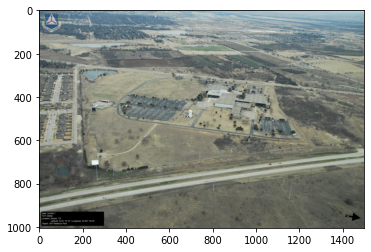

In [35]:
# Refrence
ref = plt.imread("dp-image-1-1.jpg")
plt.imshow(ref)

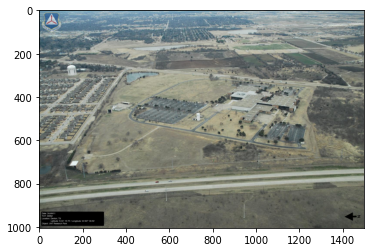

In [36]:
# Input
inp = plt.imread("dp-image-2.jpg")
plt.imshow(inp)

## Convert to Grayscale

In [37]:
plt.figure(figsize=(20, 20))

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

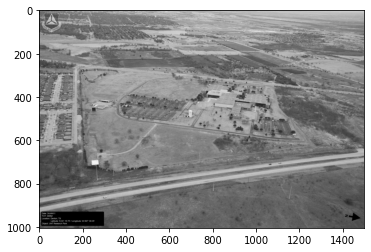

In [38]:
# Refrence
ref = skimage.color.rgb2gray(ref)
plt.imshow(ref, cmap="gray")

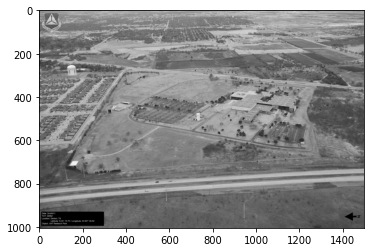

In [39]:
# Input
inp = skimage.color.rgb2gray(inp)
plt.imshow(inp, cmap="gray")

## Get Tie Points

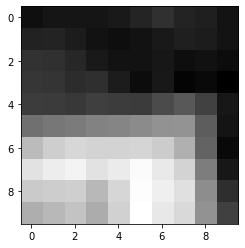

In [40]:
# Refrence image, point 1
plt.imshow(ref[685:695, 265:275], cmap="gray")
ref_p1 = (685 + 6, 265 + 6)

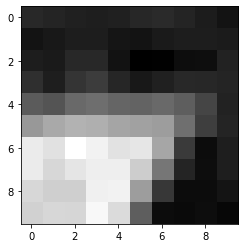

In [41]:
# Input image, point 1
plt.imshow(inp[690:700, 175:185], cmap="gray")
inp_p1 = (690 + 6, 175 + 5)

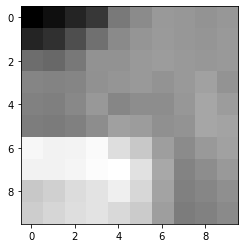

In [42]:
# Refrence image, point 2
plt.imshow(ref[565:575, 1180:1190], cmap="gray")
ref_p2 = (565 + 6, 1180 + 4)

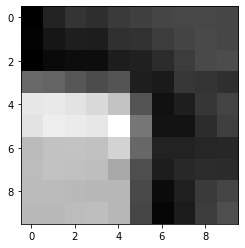

In [43]:
# Input image, point 2
plt.imshow(inp[605:615, 1220:1230], cmap="gray")
inp_p2 = (605 + 4, 1220 + 4)

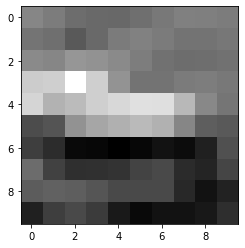

In [44]:
# Refrence image, point 3
plt.imshow(ref[420:430, 390:400], cmap="gray")
ref_p3 = (420 + 3, 390 + 2)

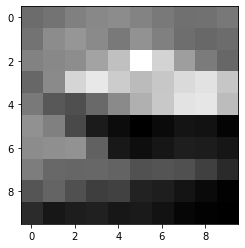

In [45]:
# Input image, point 3
plt.imshow(inp[430:440, 475:485], cmap="gray")
inp_p3 = (430 + 2, 475 + 5)

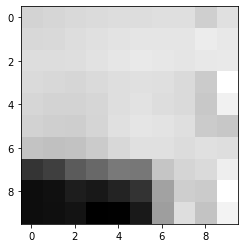

In [46]:
# Refrence image, point 4
plt.imshow(ref[425:435, 1040:1050], cmap="gray")
ref_p4 = (425 + 7, 1040 + 6)

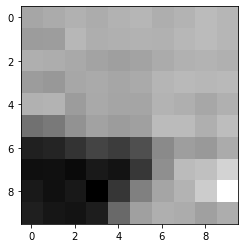

In [47]:
# Input image, point 4
plt.imshow(inp[440:450, 1150:1160], cmap="gray")
inp_p4 = (440 + 6, 1150 + 6)

## Get Inverse Mapping Affine Transform

In [48]:
# Get matrix of affine transform
ref_coords = [ref_p1, ref_p2, ref_p3, ref_p4]
inp_coords = [inp_p1, inp_p2, inp_p3, inp_p4]

# Get reference coordinate matrix
ref_matrix = np.zeros((8, ))
for i, point in enumerate(ref_coords):
    o1 = len(ref_coords)
    ref_matrix[i] = point[0]
    ref_matrix[i + o1] = point[1]

# Get input coordinate matrix
inp_matrix = np.zeros((8, 6))
for i in range(2):
    o1 = len(inp_coords) * i
    o2 = 3 * i
    for j, point in enumerate(inp_coords):
        inp_matrix[j + o1, o2] = point[0]
        inp_matrix[j + o1, o2 + 1] = point[1]
        inp_matrix[j + o1, o2 + 2] = 1

In [49]:
# Calculate coefficient values using inverse mapping
coeffs = np.linalg.pinv(inp_matrix).dot(ref_matrix)

In [50]:
# Formula for mapping values.
def to_reg(point, coeffs):
    x = point[0]
    y = point[1]
    xp = coeffs[0] * x + coeffs[1] * y + coeffs[2]
    yp = coeffs[3] * x + coeffs[4] * y + coeffs[5]
    return xp, yp

## Interpolation

Equ 2-17

v(x, y) = a*x + b*y + c*x*y + d

In [51]:
vals = []
x_vals = []
y_vals = []

def interpolate(x, y, xf, xc, yf, yc, p1, p2, p3, p4):
    h1 = x - xf
    h2 = xc - x
    v1 = y - yf
    v2 = yc - y

    top = h1*v1*p4 + h1*v2*p3 + h2*v1*p2 + h2*v2*p1
    bottom = (h1 + h2) * (v1 + v2)
    
    return top/bottom

reg = np.zeros(ref.shape)
reg1 = np.zeros(ref.shape)
for i in range(inp.shape[0]):
    for j in range(inp.shape[1]):
        x, y = to_reg((i, j), coeffs)

        xf = i - 1
        xc = i + 1
        yf = j - 1
        yc = j + 1

        if xf >=0 and xc < inp.shape[1] and yf >= 0 and yc < inp.shape[0]:

            p1 = inp[round(x), yf]
            p2 = inp[round(x), yc]
            p3 = inp[xf, round(y)]
            p4 = inp[yc, round(y)]

            # p1 = inp[xf, yf]  
            # p2 = inp[xf, yc]
            # p3 = inp[xc, yf]
            # p4 = inp[xc, yc]

            intensity = interpolate(x, y, xf, xc, yf, yc, p1, p2, p3, p4)

            reg1[round(x), round(y)] = intensity
            reg[round(x), round(y)] = inp[i, j]

        # except:
        #     continue

In [52]:
import cv2
rows, cols = inp.shape
test = np.array(ref.shape)
dst = cv2.warpAffine(inp, np.array([coeffs[:3], coeffs[3:]]), (cols, rows))
dst

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

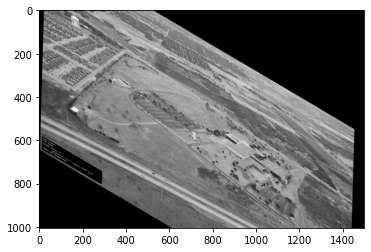

In [53]:
plt.imshow(dst, cmap="gray")

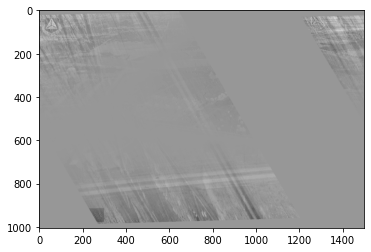

In [54]:
plt.imshow(reg1, cmap="gray")

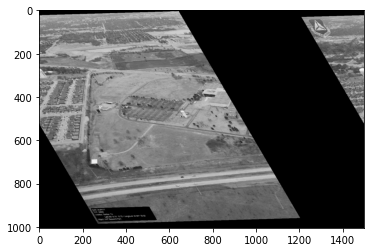

In [55]:
plt.imshow(reg, cmap="gray")

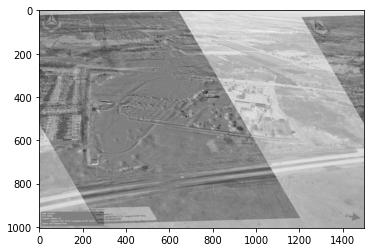

In [56]:
plt.imshow(ref-reg, cmap="gray")

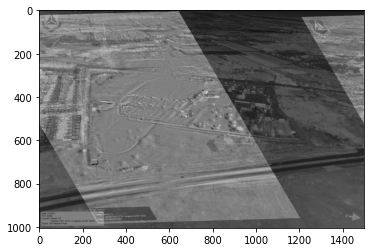

In [57]:
plt.imshow(reg-ref, cmap="gray")

## Bonus

In [58]:
# Get flow values
v, u = optical_flow_ilk(ref, inp)

In [59]:
# Compute the image change
n_rows, n_cols = ref.shape
row_vals, col_vals = np.meshgrid(np.arange(n_rows), np.arange(n_cols), indexing="ij")
inp_warp = skimage.transform.warp(ref, np.array([row_vals + v, col_vals + u]), mode="edge")

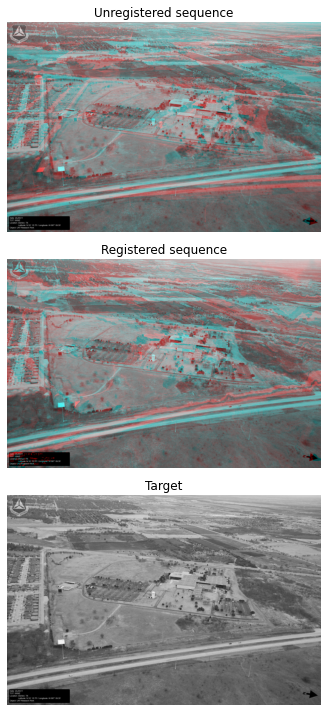

In [60]:
# build an RGB image with the unregistered sequence
seq_im = np.zeros((n_rows, n_cols, 3))
seq_im[..., 0] = inp
seq_im[..., 1] = ref
seq_im[..., 2] = ref

# build an RGB image with the registered sequence
reg_im = np.zeros((n_rows, n_cols, 3))
reg_im[..., 0] = inp_warp
reg_im[..., 1] = ref
reg_im[..., 2] = ref

# build an RGB image with the registered sequence
target_im = np.zeros((n_rows, n_cols, 3))
target_im[..., 0] = ref
target_im[..., 1] = ref
target_im[..., 2] = ref

# --- Show the result

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(5, 10))

ax0.imshow(seq_im)
ax0.set_title("Unregistered sequence")
ax0.set_axis_off()

ax1.imshow(reg_im)
ax1.set_title("Registered sequence")
ax1.set_axis_off()

ax2.imshow(target_im)
ax2.set_title("Target")
ax2.set_axis_off()

fig.tight_layout()